# Perform Fisher forecast for LSST-Y1 data constraint on cosmological parameters

In this notebook we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on cosmological parameters from an LSST-Y1 like survey.

## Load the python modules

In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

## Generate the redshift distributions

### Generate source and lens n(z)

We follow the updated analysis/modeling choices and parameters on LSST-DESC srd [repo](https://github.com/LSSTDESC/forecasting/blob/main/desc_srd/SRD_data_vectors/SRD%20parameters/lsst_desc_parameters.yaml). We use a Smail redshift distribution for galaxies
$$n(z)\propto z^2\mathrm{exp}[-(z/z_0)^\alpha],$$
divided into 5 tomographic bins. For the lens galaxies, we take $(\alpha,z_0) = (.94,.26)$ with an effective number density $n_\mathrm{eff} = 18 \text{ arcmin}^{-2}.$ For the source galaxies, we take $(\alpha,z_0) = (.870,.191)$ and $n_\mathrm{eff} = 11.2\text{ arcmin}^{-2}.$ We then divide each distribution into 5 tomographic bins with an equal number of galaxies, and then convolve each bin with a Gaussian photo-z uncertainty of .05(1+z) for sources and .02(1+z) for lenses.

In [2]:
n_source_eff = 10.
n_lens_eff = 18.

# These are the proper n(z) that give NaN in the jacobian.
# smail_nz(a,b,z0) where z^a*exp[-(z/z0)**b]
nz_s = jc.redshift.smail_nz(2, .78, 0.13, gals_per_arcmin2 = n_source_eff)
nz_l = jc.redshift.smail_nz(2, .94, .26, gals_per_arcmin2=n_lens_eff)

# NaNs in the jacobian disappear when we use these total n(z),` for example.
#nz_s = jc.redshift.smail_nz(2,2,.191, n_gals_per_armin2=n_source_eff)
#nz_l = jc.redshift.smail_nz(2,2,.26, n_gals_per_armin2=n_lens_eff)

### Retrieve $n(z)$ and $z$ files

In [3]:
data_https='https://raw.githubusercontent.com/MinhMPA/forecasting/main/updated_forecasts/datafiles/z_bins'

#### Unbinned $z$

In [4]:
LSSTY1_unbinned_z_file='z_values_unbinned.txt'
if not os.path.isfile(LSSTY1_unbinned_z_file):
    !wget -O "$LSSTY1_unbinned_z_file" "$data_https"/"$LSSTY1_unbinned_z_file"

#### Lens sample

In [5]:
LSSTY1_lens_z_file='z_bin_centers_y1_lens.txt'
if not os.path.isfile(LSSTY1_lens_z_file):
    !wget -O "$LSSTY1_lens_z_file" "$data_https"/"$LSSTY1_lens_z_file"

In [6]:
LSSTY1_lens_nz_file='nz_y1_lens.txt'
if not os.path.isfile(LSSTY1_lens_nz_file):
    !wget -O "$LSSTY1_lens_nz_file" "$data_https"/"$LSSTY1_lens_nz_file"

#### Source sample

In [7]:
LSSTY1_source_z_file='z_bin_centers_y1_source.txt'
if not os.path.isfile(LSSTY1_source_z_file):
    !wget -O "$LSSTY1_source_z_file" "$data_https"/"$LSSTY1_source_z_file"

In [8]:
LSSTY1_source_nz_file='nz_y1_source.txt'
if not os.path.isfile(LSSTY1_source_nz_file):
    !wget "$LSSTY1_source_nz_file" "$data_https"/"$LSSTY1_source_nz_file"

### Estimate $n(z)$ in bins from $n(z)$ and $z$ data

In [9]:
from numpy import loadtxt

zs = loadtxt(LSSTY1_unbinned_z_file)

#### Lens sample

In [10]:
## Specify the numbers of bins here
lens_nbins=5

zbin_center_l = loadtxt(LSSTY1_lens_z_file)
zbin_edge_l = [0.2,]
for i in range(lens_nbins):
    zbin_edge_l.append(2.*(zbin_center_l[i]-zbin_edge_l[-1])+zbin_edge_l[-1])
zbin_edge_l=np.asarray(zbin_edge_l)
zbin_width_l=zbin_edge_l[1:]-zbin_edge_l[:-1]
binned_nz_l = [loadtxt(LSSTY1_lens_nz_file, usecols=i) for i in range(lens_nbins)]

## Currently adopting the same values for both MagLim and redMaGiC samples
KDE_bw_s=0.03 # bandwidth of the KDE
KDE_zmax_l=1.2 # the cutoff redshift for lens samples in the KDE

nzs_l = [jc.redshift.kde_nz(zs.astype('float64'),
                        binned_nz_l[i].astype('float64'), 
                        bw=KDE_bw_s,
                        bwz_scale=1.0,
                        gals_per_arcmin2=nz_l(zbin_center_l[i]),
                        zmax=KDE_zmax_l)
       for i in range(lens_nbins)]

#### Source sample

In [11]:
## Specify the numbers of bins here
source_nbins=5

zbin_center_s = loadtxt(LSSTY1_source_z_file)
zbin_edge_s = [0.2,]
for i in range(source_nbins):
    zbin_edge_s.append(2.*(zbin_edge_s[i]-zbin_edge_s[-1])+zbin_edge_s[-1])
zbin_edge_s=np.asarray(zbin_edge_s)
zbin_width_s=zbin_edge_s[1:]-zbin_edge_s[:-1]
binned_nz_s = [loadtxt(LSSTY1_source_nz_file, usecols=i) for i in range(source_nbins)]

## Currently adopting the same values for both MagLim and redMaGiC samples
KDE_bw_l=0.05 # bandwidth of the KDE
KDE_zmax_s=zs.max() # the cutoff redshift for source samples in the KDE

nzs_s = [jc.redshift.kde_nz(zs.astype('float64'),
                        binned_nz_s[i].astype('float64'), 
                        bw=KDE_bw_l,
                        bwz_scale=1.0,
                        gals_per_arcmin2=nz_s(zbin_center_s[i]),
                        zmax=KDE_zmax_s)
       for i in range(source_nbins)]

In [12]:
## Some reference z and n(z) bins for LSST Y1 source sample

nzs_filename='nz_y1_srcs_5bins_srd.txt'

test_zs=np.array(loadtxt(nzs_filename,usecols=0))
test_nzs=[np.array(loadtxt(nzs_filename,usecols=i+1)) for i in range(source_nbins)]
ngals_s = [16.9477,16.8907,17.0179,16.9463,16.9608]

#nzs_s = [jc.redshift.kde_nz(zs.astype('float32'),
                        #nzs[i].astype('float32'), 
                        #bw=KDE_bw,
                        #gals_per_arcmin2=ngals_s[i],
                        #zmax=KDE_zmax_s)
       #for i in range(source_nbins)]

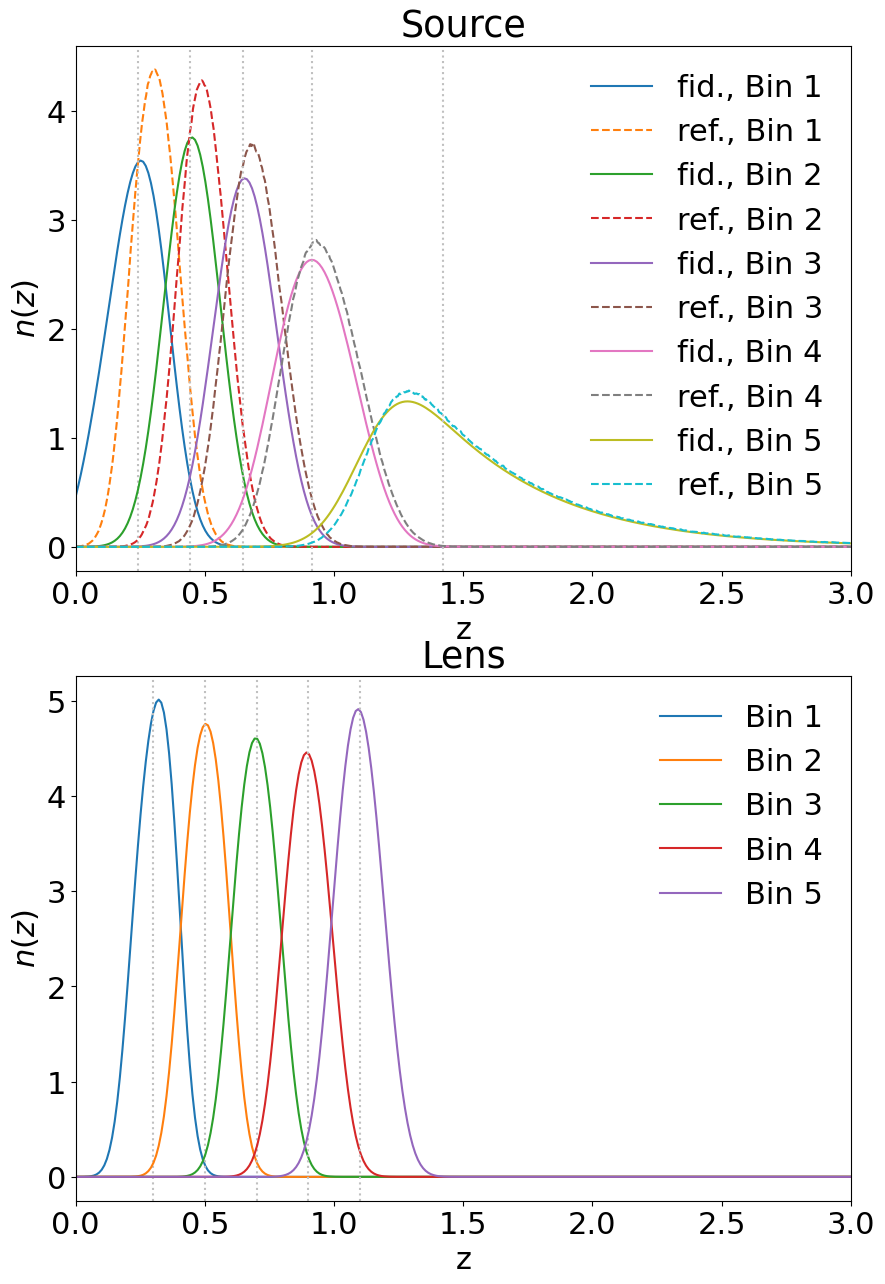

In [13]:
z = np.linspace(0.,3., 300)
fig, ax = plt.subplots(2,1, figsize=(10,15))
for i in range(min(len(nzs_s), len(nzs_l))):
    ax[0].plot(z, nzs_s[i](z), label='fid., Bin '+str(i+1))
    ax[0].plot(test_zs, test_nzs[i], ls='--',label='ref., Bin '+str(i+1))
    ax[0].axvline(x=zbin_center_s[i],ls=':',c='silver')
    ax[1].plot(z, nzs_l[i](z), label='Bin '+str(i+1))
    ax[1].axvline(x=zbin_center_l[i],ls=':',c='silver')
    ax[0].set_xlim(0.,3.)
    ax[1].set_xlim(0.,3.)
    ax[0].set_title('Source')
    ax[0].legend(frameon=False)
    ax[1].set_title('Lens')
    ax[1].legend(frameon=False)
    ax[0].set_ylabel(r'$n(z)$')
    ax[1].set_ylabel(r'$n(z)$')
    ax[0].set_xlabel(r'z')
    ax[1].set_xlabel(r'z')

In [15]:
#print(jc.scipy.integrate.romb(n_source_total, 0, .4509))

## Define utility functions that are not yet supported by jax-cosmo but useful for DES analyses 

### Specify standard input parameter(s)

In [16]:
## The number of cosmological parameters in the parameter vector, i.e. the number of cosmo parameters we vary
cosmo_param_nr=5

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_contours(fisher, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])

    # Argument validation
    assert fisher.shape[0] == fisher.shape[1], "Fisher matrix must be square"
    assert len(pos) == fisher.shape[0], "Position vector dimension must match Fisher matrix"
    assert len(inds) == 2, "Indices must specify a 2D slice of the Fisher matrix"

    cov = inv(fisher)
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellips = []
    for nstd in nstds:
       ellip = Ellipse(xy=pos[inds], width=2.0 * nstd * np.sqrt(vals[0]),
                     height=2.0 * nstd * np.sqrt(vals[1]), angle=theta, **kwargs)
       ellips.append(ellip)
    '''ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstd1 * np.sqrt(vals[0]),
                     height=2.0 * nstd1 * np.sqrt(vals[1]), angle=theta, **kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstd2 * np.sqrt(vals[0]),
                     height=2.0 * nstd2 * np.sqrt(vals[1]), angle=theta, **kwargs)'''

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(fisher, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  mat = fisher
  cov = np.linalg.inv(mat)
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))

## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo, ia, m_s, dz_s, b_l, dz_l):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    A, eta = ia
    m1, m2, m3, m4, m5 = m_s
    dz1_s, dz2_s, dz3_s, dz4_s, dz5_s = dz_s
    b1, b2, b3, b4, b5 = b_l
    dz1_l, dz2_l, dz3_l, dz4_l, dz5_l = dz_l
    return np.array([ 
        # Cosmological parameters [Omega_c, #Omega_b#, h, sigma8, ns, gamma] 
        cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.sigma8, cosmo.n_s,# cosmo.gamma,
        # Source - Galaxy IA
        A, eta,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4, m5, 
        # Source - Photometric redshift calibration systematics
        dz1_s, dz2_s, dz3_s, dz4_s, dz5_s,
        # Lens - Galaxy bias
        b1, b2, b3, b4, b5,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l, dz5_l
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    A = params[cosmo_param_nr]
    eta = params[cosmo_param_nr+1]
    m1,m2,m3,m4,m5 = params[cosmo_param_nr+2:cosmo_param_nr+7]
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s = params[cosmo_param_nr+7:cosmo_param_nr+12]
    b1,b2,b3,b4,b5 = params[cosmo_param_nr+12:cosmo_param_nr+17]
    dz1_l,dz2_l,dz3_l,dz4_l,dz5_l = params[cosmo_param_nr+17:cosmo_param_nr+22]
    return cosmo, [A, eta], [m1,m2,m3,m4,m5], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s], [b1,b2,b3,b4,b5], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l]

## Uncomment these lines below to double-check the two function behaviors
#p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              #[1., 2.,0.62],[0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0])
#print(unpack_params_vec(p))

## Define fiducial cosmological parameters and systematics parameters

### Define fiducial cosmology

#### Specify Planck18 best-fit cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [18]:
PL18_h=0.6732
PL18_omegacdm=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.8120
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma=0.55

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [19]:
fid_cosmo = jc.Cosmology(sigma8=PL18_sigma8,
                          Omega_c=PL18_omegacdm,
                          #Omega_m=PL18_omegacdm+PL18_omegab,
                          Omega_b=PL18_omegab,
                          h=PL18_h,
                          n_s=PL18_ns,
                          w0=PL18_w0, Omega_k=PL18_omegak, wa=PL18_wa)#, gamma=GR_gamma)

### Specify sky fraction

Sky coverage in square degrees and fraction

In [20]:
full_sky=41252.9612  # full sky in square degrees
lsst_sky=18000  # LSST sky coverage; in square degrees
lsst_fsky=0.4363  # fraction of the sky covered by LSST

### Specify systematic parameters for source galaxies

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have five parameters $m^i$ for five redshift bins of the source samples.
A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [21]:
m_s = [0.,0.,0.,0.,0.]

#### Photo-z calibration systematics

Similarly, we have four parameters $\Delta z_s^i$ for four redshift bins of the source samples.A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [22]:
dz_s = [0.0,0.0,0.0,0.0,0.0]

#### Intrinsic Alignment (of source galaxies)

We use the NLA model for IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [23]:
A0, eta = [.5, 0.]
z0 = .62

### Specify systematic parameters for lens galaxies

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

Here, we have five parameters $\Delta z_l^i$ for five redshift bins of the lens samples. A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [24]:
dz_l = [0.,0.,0.,0.,0.]

#### Galaxy bias systematics

Here we adopt the fiducial values for the linear galaxy bias parameters $b^i_l$ of lens galaxies from the values assumed in LSST Science Requirement Document, section D1, page 48 ([arXiv:1809.01669](https://arxiv.org/abs/1809.01669)).

In [25]:
b_l = [1.562362, 1.732963, 1.913252, 2.100644, 2.293210]
#b_l =  [1.376695, 1.451179, 1.528404, 1.607983, 1.689579, 1.772899, 1.857700, 1.943754, 2.030887, 2.118943]

### Pack a parameter vector including both cosmological and systematic parameters

In [26]:
fid_params = get_params_vec(fid_cosmo,
                            [A0, eta],
                            m_s,
                            dz_s,
                            b_l,
                            dz_l)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Specify standard input parameter(s) for the function

In [27]:
## Specify a range of multipole ell values
ell_max=3000.
ell = np.logspace(1,np.log10(ell_max))

### Put everything together and define the ```jax-cosmo``` function using just-in-time compilations

We perform a quick visual inspection and plot the mean of the first $C(\ell)$

In [28]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l,  dz_l = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0],
                         #Omega_m=cosmo_params[0]+cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

### Call the function for the first time, so there will be some waiting for compilation

In [29]:
means = compute_3x2pt_mean(fid_params,nzs_s)
#%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

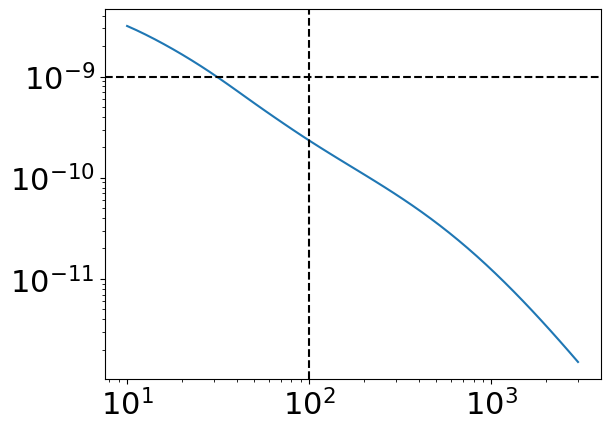

In [30]:
fig, ax = plt.subplots()
ax.loglog(ell,means[0])
#ax.set_ylim(1e-20,1e-3)
ax.axhline(y=1E-9,ls='--',c='k')
ax.axvline(x=1E2,ls='--',c='k')

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function

In [32]:
@jax.jit
def compute_gaussian_covariance(params,nzs_source,nzs_lens=nzs_l,ell=ell,f_sky=0.25, zpivot_ia=z0):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)  

    ## Define cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=cosmo_params[1],
                         #Omega_m=cosmo_params[0]+cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov

### Call the function to get the covariance and compute its inverse

The inverse of the covariance matrix is usually referred to as the *precision matrix*.

In [33]:
cov_mat = compute_gaussian_covariance(fid_params,nzs_s, f_sky = lsst_fsky)
prc_mat = np.linalg.inv(cov_mat)

## Compute the Jacobian using jax-cosmo

We wrote a function to compute the mean of the 3x2-point data vector. We can use that to compute the Jacobian using ```jax-cosmo```

Let's redefine the function to compute the mean data vector above, this time flatten the output.

In [34]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l,  dz_l = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0],
                         #Omega_m=cosmo_params[0]+cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

In [35]:
# Defining jax-cosmo jacobian
compute_3x2pt_jac = jax.jit(jax.jacfwd(compute_3x2pt_mean))
#compute_3x2pt_jac = jax.jacfwd(compute_3x2pt_mean)

In [36]:
jacobian = compute_3x2pt_jac(fid_params,nzs_s,nzs_lens=nzs_l)
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

20.7 s ± 400 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
print(np.where(np.isnan(jacobian)==True))

(Array([], dtype=int64), Array([], dtype=int64))


In [ ]:
## Compute Jacobian using reverse mode of AD as a cross-check, might run into memory issue
#compute_3x2pt_jac_rev = jax.jit(jax.jacrev(compute_3x2pt_mean))
#jacobian_rev = compute_3x2pt_jac(fid_params,nzs_s)
#print(jacobian_rev)

## Compute Fisher matrix

Putting the mean and covariance together, we can now compute the Fisher matrix.
NOTE: This is, strictly speaking, only valid for Gaussian likelihoods. With ```jax-cosmo``` there is another way to compute the Fisher matrix wherein users manually define their likelihood. We will explore it below as a double-check.

In [38]:
## Take the matrix product
fisher = jacobian.T @ prc_mat @ jacobian
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

20.9 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


```fisher``` is the full Fisher matrix. Below we can plot the whole matrix for a quick visual inspection. There should be no complain about any ```NaN``` of ```Inf``` when estimating the contours.

NOTE: This can take a while for a large Fisher matrix.

Text(0.5, 0.98, 'LSST GC')

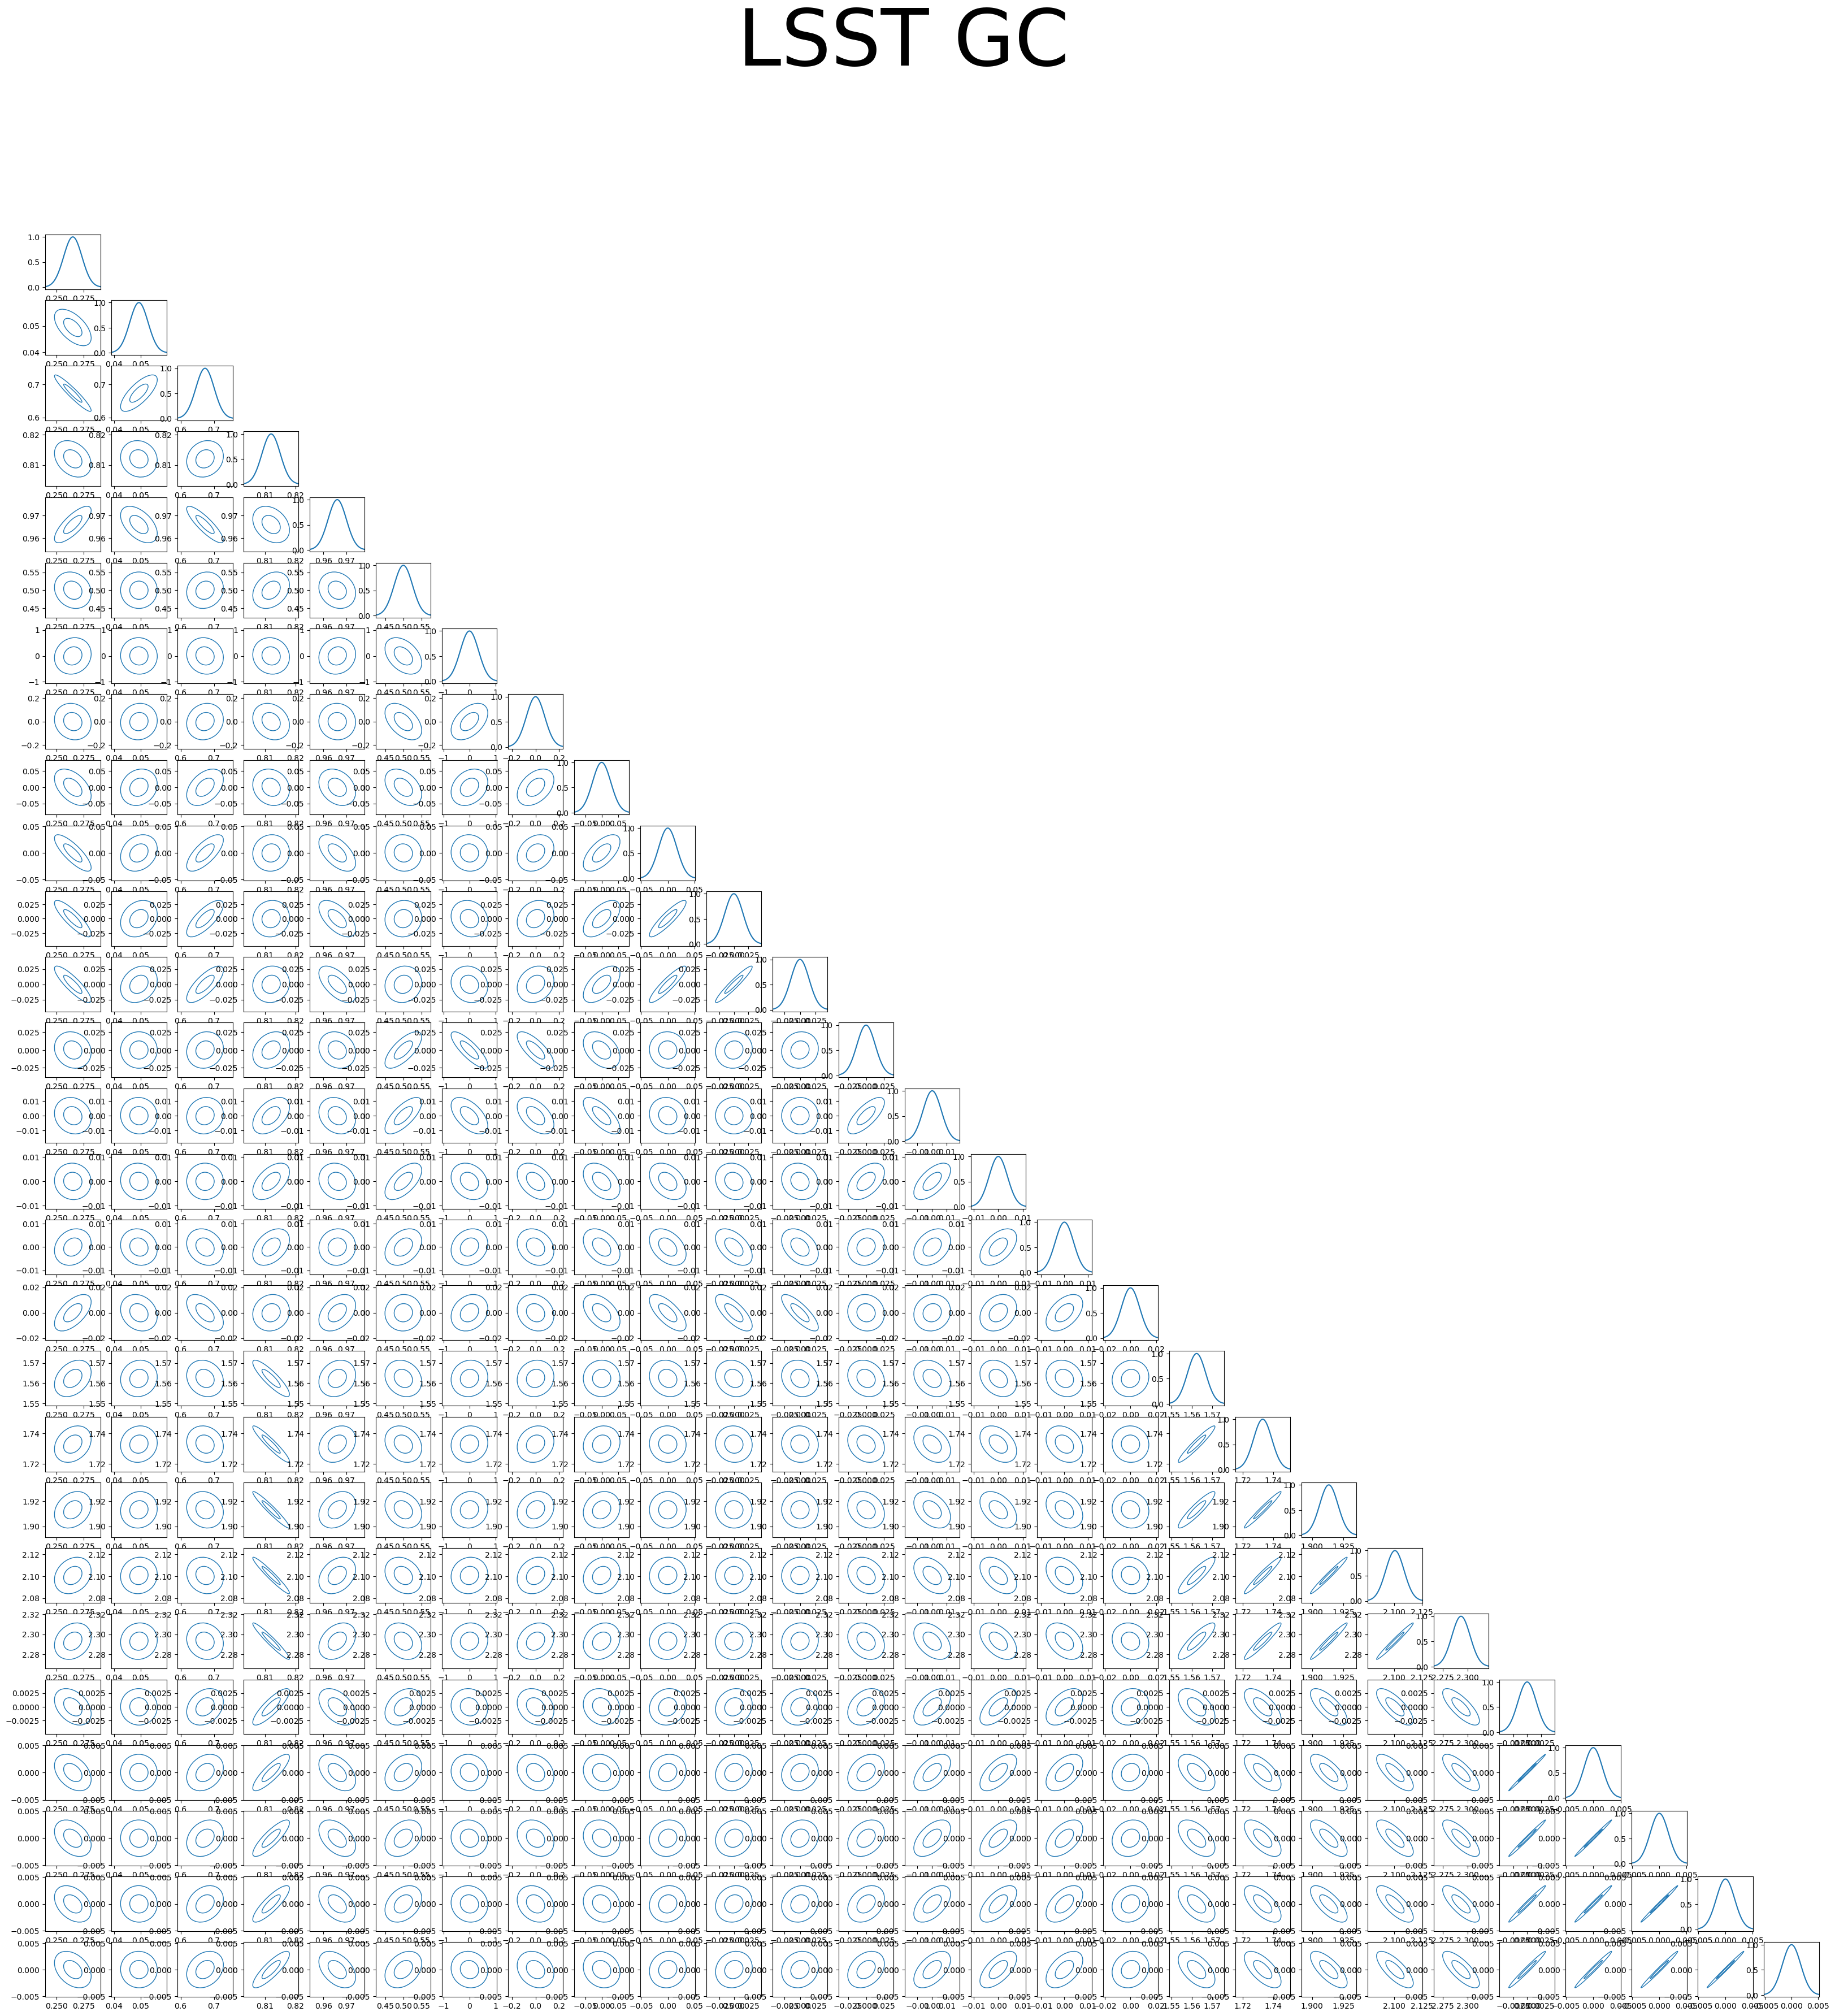

In [39]:
fig= plt.figure(figsize=(fisher.shape[0]*1.5, fisher.shape[1]*1.5))
plt.rcParams.update({
    "font.size": 10})

for i in range(fisher.shape[0]):
    for j in range(fisher.shape[1]):
        if j<i:
            plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
            plot_contours(fisher, fid_params, np.array([j,i]),fill=False,color='C0')
        if j==i:
            plt.subplot(fisher.shape[0], fisher.shape[1], i*fisher.shape[0]+j+1)
            plot_Gaussian(fisher, fid_params, i, color='C0', cl=0.9545)
fig.suptitle('LSST GC', fontsize=100)

In [ ]:
param_names = (r'$\Omega_\mathrm{c}$', r'$\Omega_\mathrm{b}$', 'h', r'$\sigma_8$', r'$n_s$', r'$\gamma$')
F_cosmo_only = np.linalg.inv(np.linalg.inv(fisher)[:cosmo_param_nr, :cosmo_param_nr])
fid_params_subset = fid_params[:F_cosmo_only.shape[0]]

fig= plt.figure(figsize=((F_cosmo_only.shape[0]+1)*4, (F_cosmo_only.shape[1]+1)*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only.shape[0]):
    for j in range(F_cosmo_only.shape[1]):
        #print(str(i)+','+str(j))
        if j<i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==0 or i==F_cosmo_only.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only, fid_params_subset, np.array([j,i]), ax=ax, fill=False,color='C0')
        if j==i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==(cosmo_param_nr-1) or j==0:
                axes.append(ax)
            plot_Gaussian(F_cosmo_only, fid_params, i, ax=ax, cl=0.9545, color='C0')
for i in np.arange(cosmo_param_nr):
    axes[i].set_ylabel(param_names[i], fontsize='xx-large')
    axes[i+cosmo_param_nr-1].set_xlabel(param_names[i], fontsize='xx-large')

fig.suptitle('LSST GC', fontsize=100)

## Compute Fisher matrix -- Alternative Method #2, using finite differencing and the [DESC Core Cosmology Library](https://github.com/LSSTDESC/CCL) ```CCL```

To gain more confidence on the Fisher evaluation and inversion by ```jax-cosmo``` and the ```autodiff``` approach, we can cross-check results with the same outputs from the finite differencing approach using ```CCL```.

NOTE: Use a very fine sampling grid in finite differencing to ensure accuracy.

### Specify standard input parameter(s) for the function

In [ ]:
raise Exception('Stop!')

In [ ]:
zsamp = np.linspace(0.,4.,2048)
cosmo_params = [PL18_omegacdm,PL18_h,PL18_sigma8,PL18_ns]

### Define utility function(s) to use with CCL

In [ ]:
# Define IA bias for DES Y1
def des_y1_ia_bias(z, A, eta, z0=0.62):
    """
    https://arxiv.org/pdf/1708.01538.pdf Sec. VII.B
    Parameters:
    -----------
    A: amplitude
    eta: redshift dependent slope
    z0: pivot redshift
    """
    return A * ((1.0 + z) / (1.0 + z0)) ** eta

### Define the function to compute the mean of the 3x2-point data vector

This is exactly the same function as above, only built with ```CCL``` and finite-differencing instead of ```jax-cosmo``` and ```autodiff```.

In [ ]:
def ccl_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell,zpivot_ia=z0,f_sky=0.25):
    """
    Returns the mean data vector provided a set of
    cosmological and nuisance parameters, using CCL
    """
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)
    ## We define the cosmology
    ## here we need to explicitly convert the ArrayImpl elements into float as CCL enforces type ```double``` for these parameters
    cosmo_ccl = ccl.Cosmology(
        Omega_c=float(cosmo_params[0]), Omega_b=float(PL18_omegab),
        h=float(cosmo_params[1]), 
        sigma8=float(cosmo_params[2]),
        n_s=float(cosmo_params[3]),
        #w0=PL18_w0, wa=PL18_wa,
        #Neff=0.,
        transfer_function='eisenstein_hu', 
        matter_power_spectrum='halofit')
    
    # Build source nz with redshift systematic bias
    # Uses same function as jax-cosmo to ensure consistency
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz_s)]
    
    # We build the tracers for each redshift bins
    tracers = [ccl.WeakLensingTracer(cosmo_ccl, (zsamp, nzs_s_sys[i](zsamp)),
                                     ia_bias=(zsamp, des_y1_ia_bias(zsamp, A, eta))) for i in range(len(nzs_source))]
    # And we keep track of a term for multiplicative biases, for shear only
    m_biases = [1.+m[i] for i in range(5)]
    m_biases += [1. for i in range(5)]

    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    tracers += [ccl.NumberCountsTracer(cosmo_ccl,
                                       has_rsd=False,
                                       dndz=(zsamp, nzs_l_sys[i](zsamp)),
                                       bias=(zsamp, b_l[i]*np.ones_like(zsamp))) for i in range(len(nzs_lens))]
    n_tracers = len(tracers)
    
    # Compute all cross correlations
    cls = []
    for i in range(n_tracers):
        for j in range(i, n_tracers):
            cls.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell)*m_biases[i]*m_biases[j])

    return np.concatenate(cls)

### Call the function to compute the mean prediction at the *same* set of fiducial parameters used above

In [ ]:
ccl_means = ccl_3x2pt_mean(fid_params,nzs_s)

### Compare the mean predictions between ```CCL``` and ```jax-cosmo```

#### All range, absolute value

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(abs(means),ls='-',color='C0',label='jax-cosmo')
ax.semilogy(abs(ccl_means),ls='--',color='C1',label='CCL')
ax.set_ylim(1e-14,1e-3)
ax.legend(frameon=False)

#### High multipoles

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(means[50*30:],ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(ccl_means[50*30:],ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

### Compute the Jacobian and Fisher matrices by finite differencing

#### Define the Jacobian

In [ ]:
import numdifftools as nd
# Defining CCL jacobian
ccl_3x2pt_jac = nd.Jacobian(ccl_3x2pt_mean, step=0.002)

#### Compute Jacobian at fiducial parameter values

In [ ]:
ccl_jacobian = ccl_3x2pt_jac(fid_params,nzs_s)

#### Visualization and comparison between ```CCL``` and ```jax-cosmo``` Jacobians

In [ ]:
fig,ax=plt.subplots()
ax.semilogy(abs(jacobian[:,0]),ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(abs(ccl_jacobian[:,0]),ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

#### Compute the Fisher matrix

We reuse the precision matrix computed earlier using ```jax-cosmo```

In [ ]:
ccl_fisher = ccl_jacobian.T @ prc_mat @ ccl_jacobian
print(ccl_fisher.shape)

In [ ]:
print(ccl_fisher)

### Compare the Fisher matrices from ```CCL``` and ```jax-cosmo```

In [ ]:
fig= plt.figure(figsize=(ccl_fisher.shape[0], ccl_fisher.shape[1]))
plt.rcParams.update({
    "font.size": 10})

for i in range(ccl_fisher.shape[0]):
    for j in range(ccl_fisher.shape[1]):
        if j<i:
            plt.subplot(ccl_fisher.shape[0],ccl_fisher.shape[1],i*ccl_fisher.shape[0]+j+1)
            #plot_contours(fisher, fid_params, np.array([j,i]),fill=False,ls='-',color='C0')
            plot_contours(ccl_fisher, fid_params, np.array([j,i]),fill=False,ls='--',color='C1')

In [ ]:
param_names = (r'$\Omega_\mathrm{CDM}$', 'h', r'$\sigma_8$', r'$n_s$')
F_cosmo_only = np.linalg.inv(np.linalg.inv(ccl_fisher)[:cosmo_param_nr, :cosmo_param_nr])
fig= plt.figure(figsize=(F_cosmo_only.shape[0]*4, F_cosmo_only.shape[1]*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only.shape[0]):
    for j in range(F_cosmo_only.shape[1]):
        if j<i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==0 or i==F_cosmo_only.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only, fid_params, np.array([j,i]),fill=False, nstd=1, color='C1', ls='--')
            plot_contours(F_cosmo_only, fid_params, np.array([j,i]),fill=False, nstd=2, color='C1', ls='--')
for i in range(cosmo_param_nr-1):
    axes[i].set_ylabel(param_names[i+1], fontsize='xx-large')
    axes[i+cosmo_param_nr-2].set_xlabel(param_names[i], fontsize='xx-large')